In [4]:
import sys
print(sys.executable)

/usr/local/opt/python@3.10/bin/python3.10


In [2]:
import os
import torch
import torchvision
from torch.utils.data import random_split
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F

In [3]:
data_dir  = "./Garbage-classification"
data_dir = os.path.join(data_dir, "Garbage classification")
classes = [cls for cls in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, cls))]

print("Classes:", classes)


Classes: ['paper', 'metal', 'cardboard', 'trash', 'glass', 'plastic']


In [4]:
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms

transformations = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()])

dataset = ImageFolder(data_dir, transform = transformations)

In [8]:
import numpy
print(numpy.__version__)
print(numpy.__file__)


1.26.4
/usr/local/lib/python3.10/site-packages/numpy/__init__.py


In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

def show_sample(img, label):
    print("Label:", dataset.classes[label], "(Class No: "+ str(label) + ")")
    plt.imshow(img.permute(1, 2, 0))

Label: cardboard (Class No: 0)


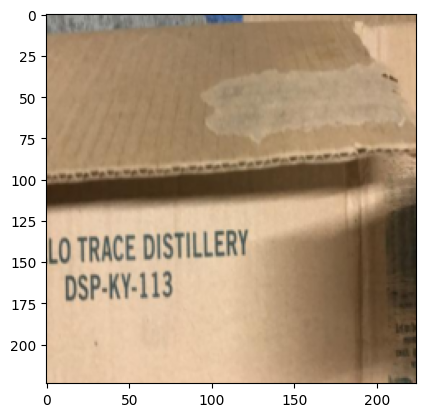

In [14]:
img, label = dataset[12]
show_sample(img, label)

In [15]:
random_seed = 42
torch.manual_seed(random_seed)

In [16]:
train_ds, val_ds, test_ds = random_split(dataset, [1593, 176, 758])
len(train_ds), len(val_ds), len(test_ds)

(1593, 176, 758)

In [17]:
from torch.utils.data.dataloader import DataLoader
batch_size = 32

In [18]:
train_dl = DataLoader(train_ds, batch_size, shuffle = True, num_workers = 4, pin_memory = True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers = 4, pin_memory = True)

In [19]:
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images, nrow = 16).permute(1, 2, 0))
        break

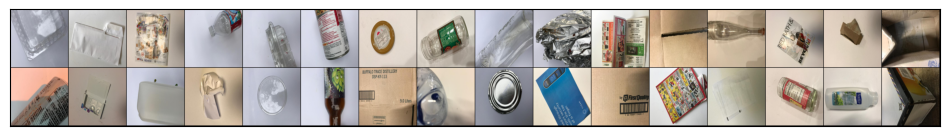

In [78]:
show_batch(train_dl)

In [20]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch {}: train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch+1, result['train_loss'], result['val_loss'], result['val_acc']))


In [21]:
class ResNet(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        # Use a pretrained model
        self.network = models.resnet18(pretrained=True)
        # Replace last layer
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Linear(num_ftrs, len(dataset.classes))
    
    def forward(self, xb):
        return torch.sigmoid(self.network(xb))

model = ResNet()

In [22]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [23]:
device = get_default_device()
device

device(type='cpu')

In [24]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
to_device(model, device)

ResNet(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runn

In [23]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [24]:
model = to_device(ResNet(), device)

In [25]:
evaluate(model, val_dl)

{'val_loss': 1.7869873046875, 'val_acc': 0.1892361044883728}

In [26]:
num_epochs = 8
opt_func = torch.optim.Adam
lr = 5.5e-5

history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)


Epoch 1: train_loss: 1.4891, val_loss: 1.3252, val_acc: 0.8073
Epoch 2: train_loss: 1.2511, val_loss: 1.2307, val_acc: 0.8733
Epoch 3: train_loss: 1.1575, val_loss: 1.1920, val_acc: 0.9219
Epoch 4: train_loss: 1.1083, val_loss: 1.1749, val_acc: 0.9062
Epoch 5: train_loss: 1.0823, val_loss: 1.1734, val_acc: 0.8906
Epoch 6: train_loss: 1.0710, val_loss: 1.1523, val_acc: 0.9236
Epoch 7: train_loss: 1.0621, val_loss: 1.1468, val_acc: 0.9097
Epoch 8: train_loss: 1.0591, val_loss: 1.1481, val_acc: 0.9184


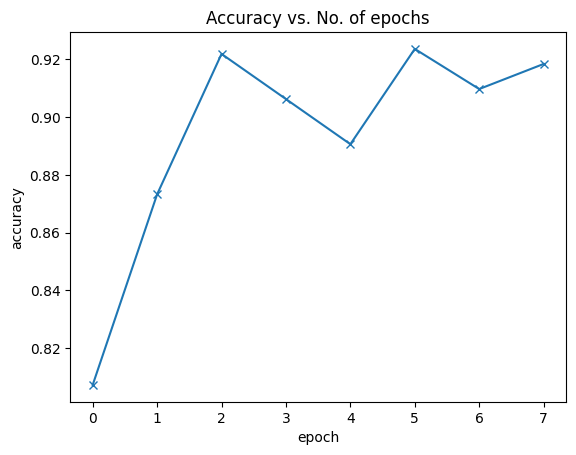

In [27]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

plot_accuracies(history)

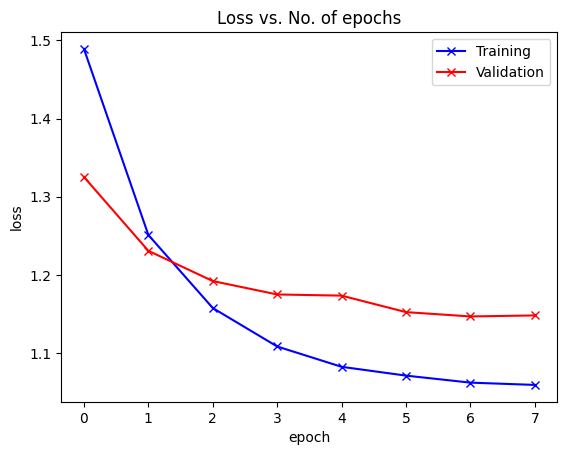

In [28]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

plot_losses(history)

In [29]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    prob, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return dataset.classes[preds[0].item()]

Label: metal , Predicted: metal


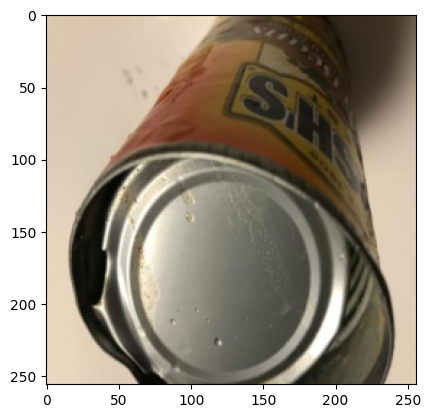

In [30]:
img, label = test_ds[17]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))


Label: glass , Predicted: glass


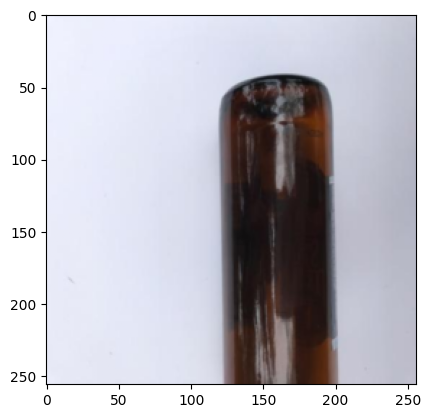

In [31]:
img, label = test_ds[23]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))


Label: plastic , Predicted: plastic


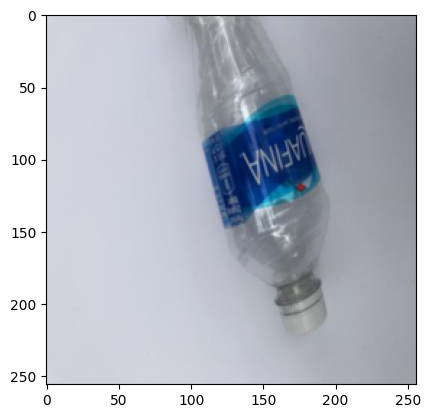

In [32]:
img, label = test_ds[51]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))


In [33]:
import urllib.request

# Replacing with clean, working image URLs
urllib.request.urlretrieve("https://5.imimg.com/data5/IA/TL/MY-33592295/water-bottle.jpg", "plastic.jpg")
urllib.request.urlretrieve("https://static.grainger.com/rp/s/is/image/Grainger/11R416_AS01?$zmmain$", "cardboard.jpg")
urllib.request.urlretrieve("https://tagliquorstores.com/cdn/shop/products/Budweiser-Beer-740ml-Can.jpg?v=1650159579", "cans.jpg")
urllib.request.urlretrieve("https://www.wineandbeersupply.com/cdn/shop/products/WAU-AG-cork_630x700.jpg?v=1550676129", "wine-trash.jpg")
urllib.request.urlretrieve("https://media.istockphoto.com/id/172415947/photo/crumpled-wad-of-paper-for-trash.jpg?s=612x612&w=0&k=20&c=b0Ty6OGTC8O3AL1c6CFd7tRBqA1ePjoYsYSDsZqMipc=", "paper-trash.jpg")


('paper-trash.jpg', <http.client.HTTPMessage at 0x11d956470>)

In [34]:
loaded_model = model

In [35]:
from PIL import Image
from pathlib import Path

def predict_external_image(image_name):
    image = Image.open(Path('./' + image_name))

    example_image = transformations(image)
    plt.imshow(example_image.permute(1, 2, 0))
    print("The image resembles", predict_image(example_image, loaded_model) + ".")


The image resembles metal.


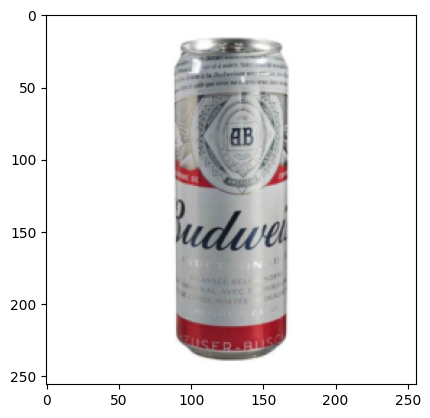

In [36]:
predict_external_image('cans.jpg')

The image resembles cardboard.


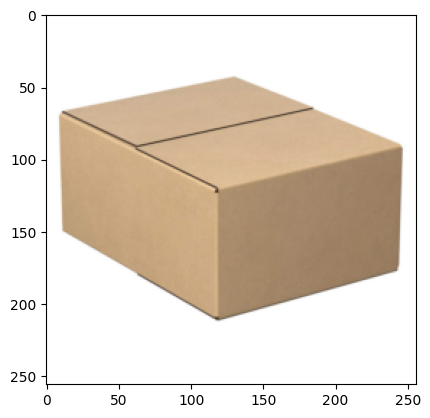

In [37]:
predict_external_image('cardboard.jpg')

The image resembles plastic.


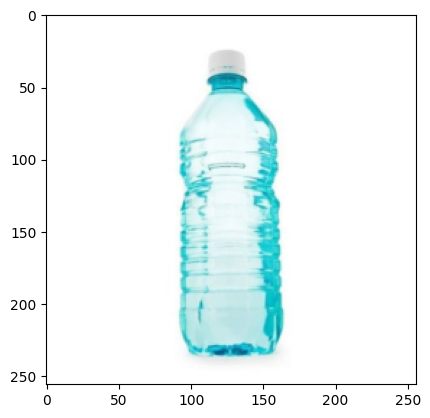

In [38]:
predict_external_image('plastic.jpg')

The image resembles glass.


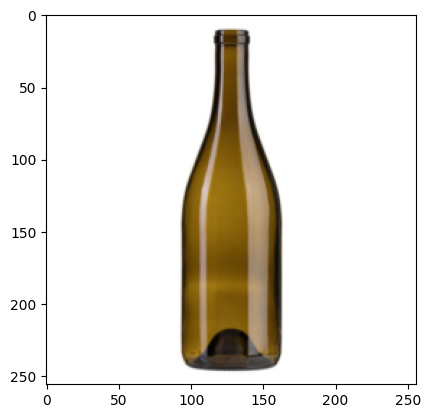

In [39]:
predict_external_image('wine-trash.jpg')

The image resembles trash.


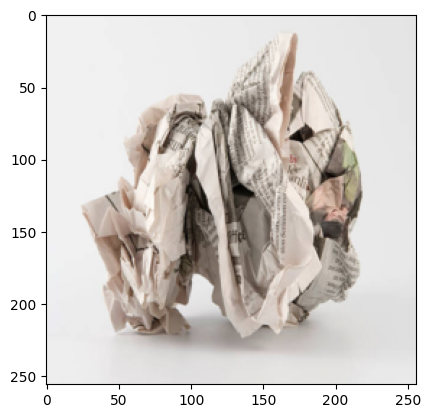

In [40]:
predict_external_image('paper-trash.jpg')

In [41]:
import torch

torch.save(model.state_dict(), "model.pth")


In [25]:
from sklearn.metrics import classification_report, confusion_matrix

import torch
from tqdm import tqdm

def evaluate_model(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in tqdm(dataloader):
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return all_preds, all_labels


In [26]:
test_dl = DataLoader(test_ds, batch_size=32, shuffle=False)
test_dl = DeviceDataLoader(test_dl, device)


In [65]:
y_pred, y_true = evaluate_model(model, test_dl, device)


100%|██████████| 24/24 [00:41<00:00,  1.73s/it]


In [66]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred, target_names=dataset.classes))

              precision    recall  f1-score   support

   cardboard       0.90      0.96      0.93       113
       glass       0.90      0.91      0.90       144
       metal       0.87      0.97      0.92       129
       paper       0.94      0.95      0.95       175
     plastic       0.93      0.86      0.90       149
       trash       0.97      0.69      0.80        48

    accuracy                           0.91       758
   macro avg       0.92      0.89      0.90       758
weighted avg       0.92      0.91      0.91       758



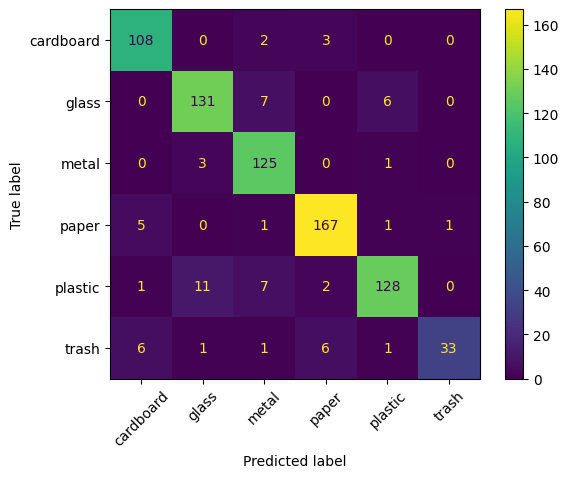

In [67]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(y_true, y_pred, display_labels=dataset.classes, xticks_rotation=45)

In [27]:
import timm
import torch.nn as nn

class ViTClassifier(nn.Module):
    def __init__(self, num_classes):
        super(ViTClassifier, self).__init__()
        self.model = timm.create_model(
            'vit_tiny_patch16_224', 
            pretrained=True, 
            num_classes=num_classes
        )

    def forward(self, x):
        return self.model(x)


/usr/local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [28]:
vit_model = ViTClassifier(len(classes)).to(device)


In [85]:
optimizer = torch.optim.Adam(vit_model.parameters(), lr=lr)
history_vit = fit(num_epochs, vit_model, train_dl, val_dl, optimizer)


Epoch [1/8] Train Loss: 0.7967, Train Acc: 70.37% Val Loss: 0.5581, Val Acc: 81.25%
Epoch [2/8] Train Loss: 0.2040, Train Acc: 93.91% Val Loss: 0.4342, Val Acc: 85.80%
Epoch [3/8] Train Loss: 0.0570, Train Acc: 99.18% Val Loss: 0.3775, Val Acc: 87.50%
Epoch [4/8] Train Loss: 0.0238, Train Acc: 99.75% Val Loss: 0.4200, Val Acc: 87.50%
Epoch [5/8] Train Loss: 0.0153, Train Acc: 99.81% Val Loss: 0.4190, Val Acc: 87.50%
Epoch [6/8] Train Loss: 0.0081, Train Acc: 99.81% Val Loss: 0.4125, Val Acc: 89.20%
Epoch [7/8] Train Loss: 0.0058, Train Acc: 99.87% Val Loss: 0.4395, Val Acc: 87.50%
Epoch [8/8] Train Loss: 0.0070, Train Acc: 99.81% Val Loss: 0.4298, Val Acc: 88.07%


In [86]:
torch.save(vit_model.state_dict(), "vit_model.pth")


In [29]:

vit_model.load_state_dict(torch.load("vit_model.pth", map_location=torch.device('cpu')))
vit_model.eval()

ViTClassifier(
  (model): VisionTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 192, kernel_size=(16, 16), stride=(16, 16))
      (norm): Identity()
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (patch_drop): Identity()
    (norm_pre): Identity()
    (blocks): Sequential(
      (0): Block(
        (norm1): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=192, out_features=576, bias=True)
          (q_norm): Identity()
          (k_norm): Identity()
          (attn_drop): Dropout(p=0.0, inplace=False)
          (norm): Identity()
          (proj): Linear(in_features=192, out_features=192, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (ls1): Identity()
        (drop_path1): Identity()
        (norm2): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=192, out_features=768, bias=True)
          (ac

In [30]:
from sklearn.metrics import classification_report, confusion_matrix
import torch
from tqdm import tqdm


In [32]:
def evaluate_model_metrics(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in tqdm(dataloader):
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Generate classification report
    report = classification_report(all_labels, all_preds, target_names=classes, digits=4)
    cm = confusion_matrix(all_labels, all_preds)

    return report, cm


In [34]:
report_vit, cm_vit = evaluate_model_metrics(vit_model, test_dl, device)

print("Classification Report for ViT Model:\n")
print(report_vit)


100%|██████████| 24/24 [00:15<00:00,  1.50it/s]

Classification Report for ViT Model:

              precision    recall  f1-score   support

       paper     0.9224    0.9469    0.9345       113
       metal     0.8544    0.9375    0.8940       144
   cardboard     0.9291    0.9147    0.9219       129
       trash     0.9227    0.9543    0.9382       175
       glass     0.9071    0.8523    0.8789       149
     plastic     0.9167    0.6875    0.7857        48

    accuracy                         0.9063       758
   macro avg     0.9087    0.8822    0.8922       758
weighted avg     0.9073    0.9063    0.9052       758



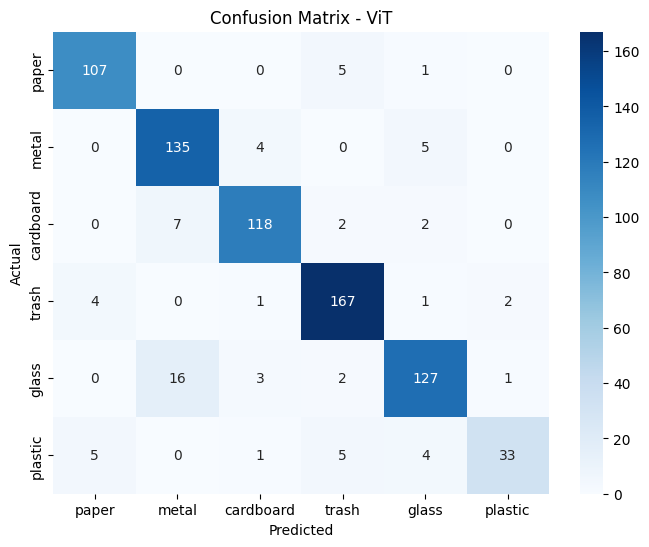

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
sns.heatmap(cm_vit, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - ViT")
plt.show()


In [39]:
# These need to be gathered during evaluation
all_labels = []
resnet_preds = []
vit_preds = []

# Assuming you're evaluating both models one after the other
for images, labels in val_dl:
    images = images.to(device)
    labels = labels.to(device)

    # For ResNet
    outputs_resnet = model(images)
    _, preds_resnet = torch.max(outputs_resnet, 1)
    resnet_preds.extend(preds_resnet.cpu().numpy())

    # For ViT
    outputs_vit = vit_model(images)
    _, preds_vit = torch.max(outputs_vit, 1)
    vit_preds.extend(preds_vit.cpu().numpy())

    all_labels.extend(labels.cpu().numpy())


In [40]:
import torch

y_true = torch.tensor(all_labels)
y_pred_resnet = torch.tensor(resnet_preds)
y_pred_vit = torch.tensor(vit_preds)

torch.save(y_true, "val_labels.pth")
torch.save(y_pred_resnet, "resnet_preds.pth")
torch.save(y_pred_vit, "vit_preds.pth")
